<a href="https://colab.research.google.com/github/Txlu-OG/AI-in-Healthcare/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Risk Prediction using Machine Learning

## Project Overview

This notebook develops and evaluates a machine learning model that predicts the risk of stroke using patient demographic, lifestyle, and clinical information. The goal is to build a realistic AI application that can support early identification of high risk individuals and demonstrate the full pipeline from data preprocessing to deployment in Google Colab.

Stroke is a leading cause of mortality and long term disability worldwide. Many of its risk factors, such as hypertension, smoking, and uncontrolled glucose, are modifiable. A data driven risk prediction model can help clinicians and health systems focus attention on patients who are more likely to benefit from closer monitoring and preventive interventions.

This project follows the requirements of the final assignment:

- Define a real world problem that can be addressed with machine learning.
- Select a suitable dataset from an online repository.
- Explore and preprocess the data.
- Select, train, and tune appropriate models.
- Evaluate performance using relevant metrics.
- Add explainability and basic fairness checks.
- Deploy the model within Colab through a simple interactive interface.

The rest of this notebook is organized into the following sections:

1. Problem definition and dataset selection  
2. Data exploration and preprocessing  
3. Model selection, training, and tuning  
4. Model evaluation  
5. Explainability with SHAP and LIME  
6. Fairness analysis by gender  
7. Interactive deployment in Google Colab  


In [ ]:

# Stroke Risk Prediction Project

# 1. Install extra libraries (run once per runtime)
!pip install shap lime fairlearn

# 2. Imports and global settings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import shap
from lime.lime_tabular import LimeTabularExplainer

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

import ipywidgets as widgets
from ipywidgets import interact

from google.colab import files
import io

In [ ]:
# Plot style
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

## 1. Problem Definition and Dataset Selection

### 1.1 Problem definition

The prediction task in this project is:

> **Given information about a patient’s demographics, clinical history, and lifestyle, predict whether the patient has had a stroke or not.**

This is a **binary classification** problem where the target variable `stroke` takes the value:

- `0` for patients without a recorded stroke  
- `1` for patients with a recorded stroke  

This problem is clinically meaningful because:

- Stroke is a major cause of death and long term disability.  
- Many underlying risk factors are modifiable or can be better controlled.  
- Identifying patients with higher predicted risk can support targeted prevention, counseling, and closer follow up.

### 1.2 Dataset description

For this project, I use the **Stroke Prediction Dataset** from Kaggle. The dataset contains patient level records with the following types of information:

- Demographics, for example `gender`, `age`, `Residence_type`  
- Clinical history, for example `hypertension`, `heart_disease`  
- Lifestyle and socioeconomic variables, for example `smoking_status`, `work_type`, `ever_married`  
- Clinical measurements such as `avg_glucose_level` and `bmi`  
- Target variable: `stroke`

Key properties of the dataset:

- Each row represents one patient.  
- The target `stroke` is relatively rare, which makes this a realistic and slightly imbalanced classification problem.  
- The dataset includes both numerical and categorical variables, which requires encoding and careful preprocessing.

In the next step, I load the CSV file into a pandas DataFrame and perform an initial inspection of its structure and contents.


In [ ]:
# 3. Load dataset into pandas
print("Please upload healthcare-dataset-stroke-data.csv downloaded from Kaggle.")
uploaded = files.upload()

csv_name = list(uploaded.keys())[0]  # assume first uploaded file is the dataset
df = pd.read_csv(io.BytesIO(uploaded[csv_name]))

print("First 5 rows of the raw dataset:")
display(df.head())

Please upload healthcare-dataset-stroke-data.csv downloaded from Kaggle.


Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (4).csv
First 5 rows of the raw dataset:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Data Exploration and Preprocessing

### 2.1 Initial exploration

Before building any model, it is important to understand the structure and quality of the dataset. In this section, I:

- Inspect the shape of the data (number of rows and columns).  
- Examine data types of each column.  
- Check for missing values in each variable.  
- Look at the class balance of the target `stroke`.

These steps help identify:

- Which columns are numerical vs categorical.  
- Where there are missing values that will require imputation.  
- Whether the target is highly imbalanced, which will affect model choice and evaluation.


In [ ]:
# 4. Basic EDA: structure and missing values
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nClass balance (stroke column):")
print(df["stroke"].value_counts())
print("\nClass balance (%):")
print(df["stroke"].value_counts(normalize=True) * 100)

Shape: (5110, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Missing values per column:
id                     0
gender                 0
age                    0
hypertension           0

### 2.2 Visual exploration

Next, I use basic visualizations to better understand the distributions and relationships in the data. The plots include:

- Histogram of **age**  
- Histogram of **average glucose level**  
- Histogram of **BMI**  
- Count plot of stroke vs no stroke  
- Bar plot of stroke rate by gender

These plots help answer questions such as:

- What is the age distribution in this dataset?  
- Are glucose levels and BMI roughly symmetric or skewed?  
- How rare is stroke relative to non stroke?  
- Are there visible differences in stroke occurrence between males and females?

The goal is not to perform an exhaustive analysis, but to gain enough intuition about the data to guide preprocessing and model selection.


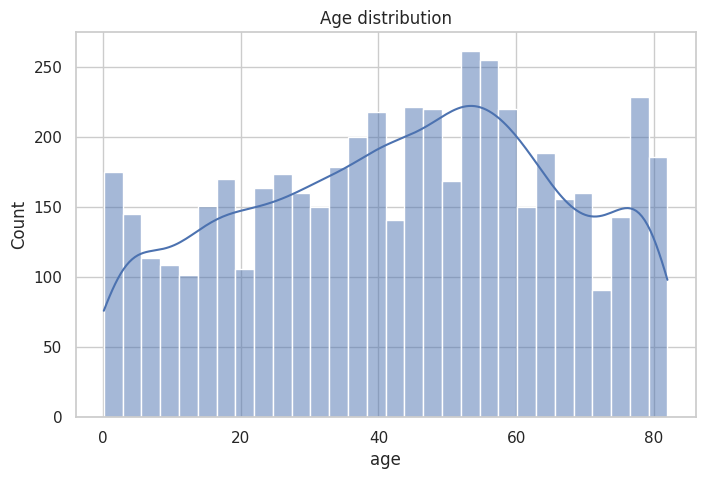

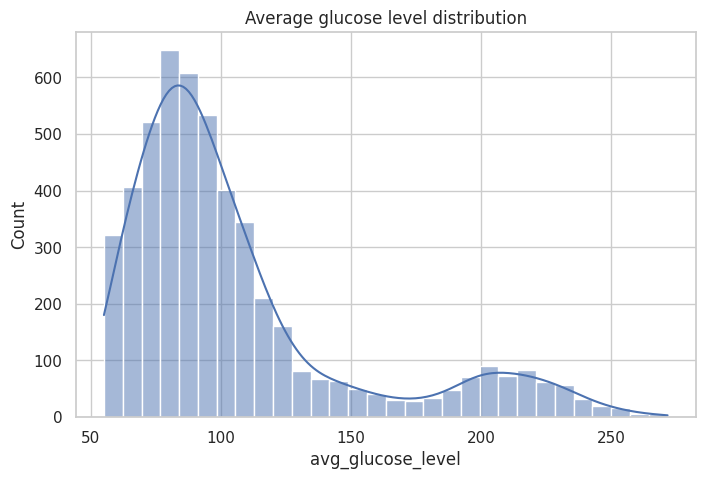

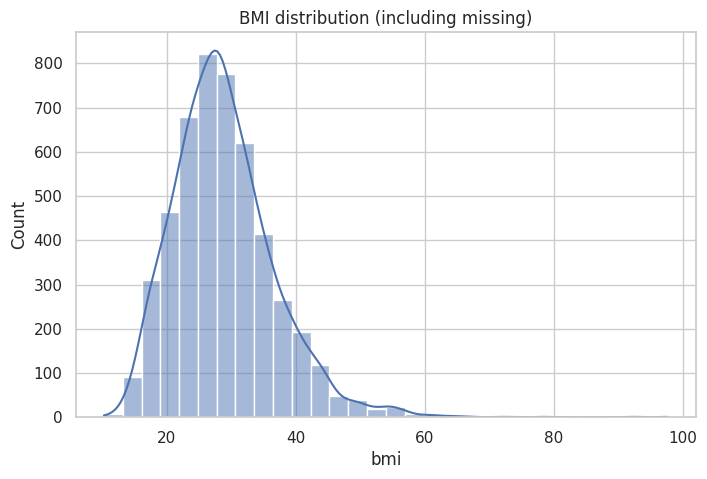

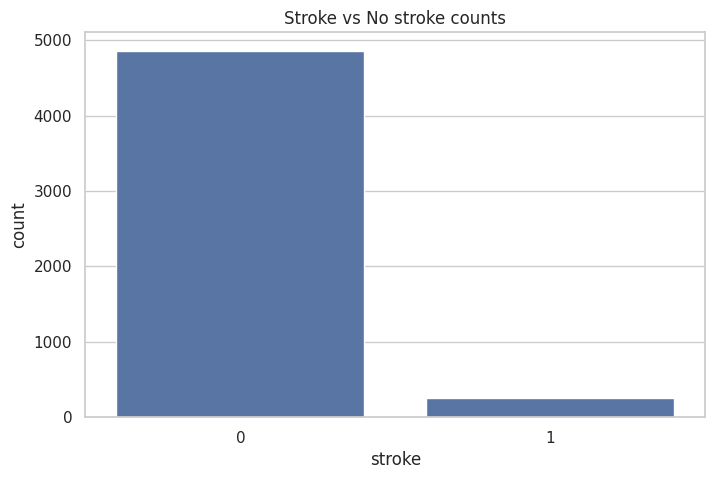

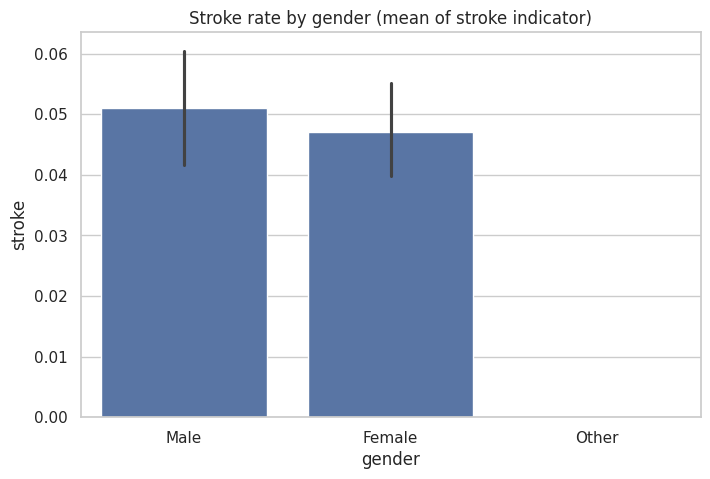

In [ ]:
# 5. Basic visualizations
# Distribution of age
sns.histplot(data=df, x="age", bins=30, kde=True)
plt.title("Age distribution")
plt.show()

# Distribution of avg_glucose_level
sns.histplot(data=df, x="avg_glucose_level", bins=30, kde=True)
plt.title("Average glucose level distribution")
plt.show()

# Distribution of BMI
sns.histplot(data=df, x="bmi", bins=30, kde=True)
plt.title("BMI distribution (including missing)")
plt.show()

# Stroke counts
sns.countplot(data=df, x="stroke")
plt.title("Stroke vs No stroke counts")
plt.show()

# Stroke rate by gender
sns.barplot(data=df, x="gender", y="stroke", estimator=np.mean)
plt.title("Stroke rate by gender (mean of stroke indicator)")
plt.show()

### 2.3 Data cleaning and handling missing values

The raw dataset contains a few issues that need to be addressed before modeling:

1. **Rare gender category**  
   - The `gender` column includes a very small number of rows labeled `"Other"`.  
   - Because this category is extremely rare, it can complicate modeling without adding meaningful information.  
   - I remove rows with `gender == "Other"` to keep only `"Male"` and `"Female"` categories.

2. **BMI type conversion and missing values**  
   - The `bmi` column is stored as text and may contain non numeric values.  
   - I convert `bmi` to numeric using `pd.to_numeric` and coerce invalid entries to `NaN`.  
   - I then impute missing `bmi` values using the median BMI, which is a robust choice that is not overly influenced by extreme values.

3. **Dropping identifier column**  
   - The `id` column is a simple identifier and does not contain predictive information.  
   - I drop the `id` column from the dataset to avoid accidentally using it as a feature.

After these steps, I verify that there are no remaining missing values in the features that will be used for modeling.


In [ ]:
# 6. Data cleaning
print("Number of 'Other' gender rows before:", (df["gender"] == "Other").sum())
df = df[df["gender"] != "Other"]

# Convert BMI to numeric and impute missing BMI with median
df["bmi"] = pd.to_numeric(df["bmi"], errors="coerce")
bmi_median = df["bmi"].median()
df["bmi"].fillna(bmi_median, inplace=True)

# Drop the 'id' column which is just an identifier
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

print("\nAfter cleaning:")
print(df.isna().sum())
print("Shape after cleaning:", df.shape)

print("First 5 rows after cleaning:")
display(df.head())

# Keep a copy for fairness analysis (original columns)
df_clean = df.copy()

# 7. One-hot encoding and train test split
target_col = "stroke"

categorical_cols = ["gender", "ever_married", "work_type",
                    "Residence_type", "smoking_status"]

Number of 'Other' gender rows before: 1

After cleaning:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Shape after cleaning: (5109, 11)
First 5 rows after cleaning:


/tmp/ipython-input-3611942280.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(bmi_median, inplace=True)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 2.4 Encoding categorical variables and train–test split

The dataset includes several categorical variables:

- `gender`  
- `ever_married`  
- `work_type`  
- `Residence_type`  
- `smoking_status`  

Machine learning models in scikit learn require numerical input, so I apply one hot encoding to these categorical columns using `pd.get_dummies` without dropping any levels. This produces a set of binary indicator columns for each category.

After encoding, I separate the data into:

- `X` - the feature matrix, containing all predictor variables  
- `y` - the target vector, the `stroke` column  

To evaluate model performance fairly, I split the data into training and test sets using `train_test_split` with:

- 80 percent of the data used for training  
- 20 percent used for testing  
- `stratify=y` to preserve the class imbalance proportion in both sets  

This ensures that the tuned model is evaluated on data that was not used during training.


In [ ]:
# One-hot encode all categorical features (no drop_first to keep mapping simple)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

print("Encoded feature shape:", X.shape)

# Stratified split to preserve rare stroke class proportion
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Stroke rate in train:", y_train.mean())
print("Stroke rate in test:", y_test.mean())

Encoded feature shape: (5109, 20)
Train shape: (4087, 20)
Test shape: (1022, 20)
Stroke rate in train: 0.04869097137264497
Stroke rate in test: 0.04892367906066536


## 3. Model Selection and Development

### 3.1 Choice of models

This project focuses on supervised classification models that are well suited to tabular health data.

I start with two baseline models:

1. **Random Forest Classifier**  
   - An ensemble of decision trees.  
   - Handles non linear relationships and complex feature interactions.  
   - Generally robust to outliers and unscaled features.  
   - I use `class_weight="balanced"` to give more emphasis to the minority stroke class.

2. **Logistic Regression**  
   - A linear model that estimates the log odds of the positive class.  
   - Provides interpretable coefficients that show the direction of association between predictors and stroke.  
   - Also uses `class_weight="balanced"` to partially correct for class imbalance.

Training these two models provides a baseline understanding of achievable performance and gives a comparison between a simple linear model and a more flexible tree based ensemble.


In [ ]:
# 8. Baseline models (Random Forest and optional Logistic Regression)

# Baseline Random Forest
rf_baseline = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

y_pred_rf = rf_baseline.predict(X_test)
y_proba_rf = rf_baseline.predict_proba(X_test)[:, 1]

print("\nRandom Forest baseline performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Optional Logistic Regression for comparison
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_lr, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_lr, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Random Forest baseline performance:
Accuracy: 0.949119373776908
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC-AUC: 0.7706584362139918

Classification report (Random Forest):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Logistic Regression performance:
Accuracy: 0.7367906066536204
Precision: 0.13377926421404682
Recall: 0.8
F1-score: 0.22922636103151864
ROC-AUC: 0.8394855967078189


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3.2 Baseline model performance

After fitting the baseline Random Forest and Logistic Regression models on the training data, I evaluate them on the held out test set using the following metrics:

- **Accuracy**  
- **Precision** for the positive class (stroke)  
- **Recall** for the positive class (stroke)  
- **F1-score** for the positive class  
- **ROC AUC** (Area Under the Receiver Operating Characteristic Curve)

These metrics together give a more complete picture of performance:

- Accuracy alone can be misleading when the stroke class is rare.  
- Precision and recall focus specifically on the stroke class.  
- F1-score balances precision and recall in a single number.  
- ROC AUC summarizes the trade off between true positive rate and false positive rate across thresholds.

I also visualize:

- A **confusion matrix** for the baseline Random Forest to see counts of true and false positives and negatives.  
- A **ROC curve** to visualize discrimination ability across thresholds.

These baseline results serve as a reference point for later hyperparameter tuning.


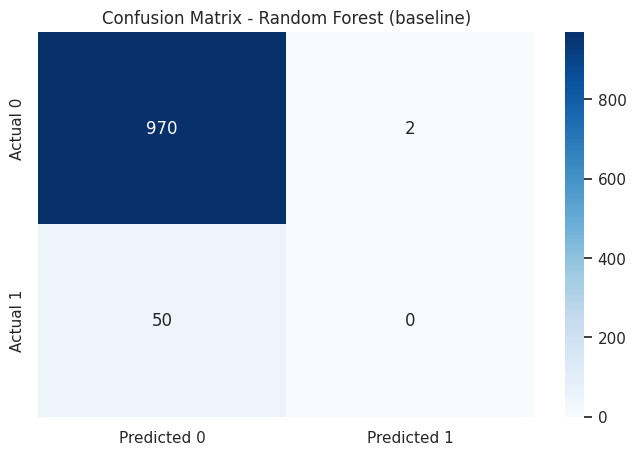

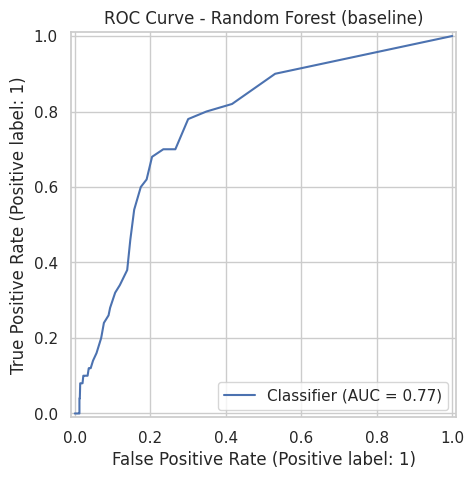

In [ ]:
# 9. Confusion matrix and ROC curve for Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"],
                     columns=["Predicted 0", "Predicted 1"])

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest (baseline)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC Curve - Random Forest (baseline)")
plt.show()

### 3.3 Hyperparameter tuning with cross validation

To improve model performance, I tune the Random Forest hyperparameters using `GridSearchCV` with 5 fold cross validation and ROC AUC as the scoring metric.

The following hyperparameters are explored:

- `n_estimators` - number of trees in the forest  
- `max_depth` - maximum depth of each tree  
- `min_samples_split` - minimum number of samples required to split an internal node  
- `min_samples_leaf` - minimum number of samples required to be a leaf node  

For each combination of hyperparameters, `GridSearchCV`:

1. Splits the training data into 5 folds.  
2. Trains the model on 4 folds and validates on the remaining fold.  
3. Repeats this process so each fold is used as a validation set once.  
4. Computes the mean ROC AUC across folds.

The best performing combination is selected as `best_estimator_`. This tuned Random Forest is then retrained on the full training data and evaluated on the test set. This process helps reduce overfitting and increase generalization performance.


In [ ]:
# 10. Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\nPerformance of tuned Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_best, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_best, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV ROC-AUC: 0.8303728123586736

Performance of tuned Random Forest:
Accuracy: 0.7015655577299413
Precision: 0.11711711711711711
Recall: 0.78
F1-score: 0.20365535248041775
ROC-AUC: 0.8268518518518518


## 4. Model Evaluation

### 4.1 Performance of tuned Random Forest

Using the best hyperparameters from the grid search, I evaluate the tuned Random Forest model on the test set. The same metrics are reported:

- Accuracy  
- Precision (stroke class)  
- Recall (stroke class)  
- F1-score (stroke class)  
- ROC AUC  

I also plot:

- The **confusion matrix** for the tuned model, to see how the tuning changed the balance between correct and incorrect predictions.  
- The **ROC curve** based on predicted probabilities from the tuned model.

In the written report, I compare:

- Tuned Random Forest vs baseline Random Forest  
- Tuned Random Forest vs Logistic Regression  

and comment on whether tuning led to a meaningful improvement and how well the final model identifies stroke cases.


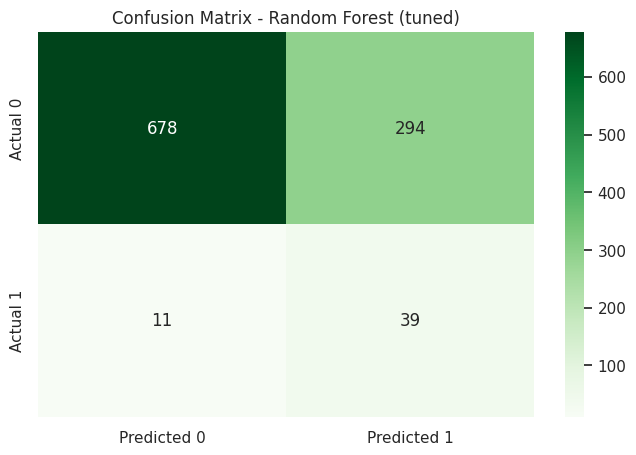

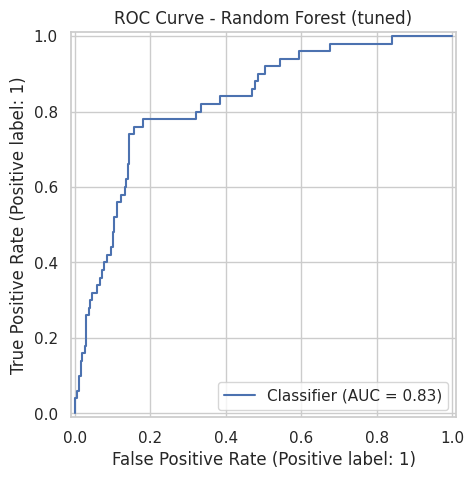

In [ ]:
# Plot confusion matrix and ROC for tuned model
cm_best = confusion_matrix(y_test, y_pred_best)
cm_best_df = pd.DataFrame(cm_best, index=["Actual 0", "Actual 1"],
                          columns=["Predicted 0", "Predicted 1"])

sns.heatmap(cm_best_df, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest (tuned)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title("ROC Curve - Random Forest (tuned)")
plt.show()

## 5. Model Explainability with SHAP

### 5.1 Global feature importance using SHAP

To understand how the tuned Random Forest makes predictions, I use **SHapley Additive exPlanations (SHAP)**. SHAP provides a consistent way to attribute the prediction of a model to each feature for each instance.

Key ideas:

- SHAP values estimate how much each feature contributes to moving the model prediction away from a baseline value.  
- Positive SHAP values push the prediction toward a higher probability of stroke.  
- Negative SHAP values push the prediction toward a lower probability of stroke.

In this notebook, I:

1. Fit a `TreeExplainer` on the tuned Random Forest.  
2. Compute SHAP values for a sample of training observations.  
3. Produce a **summary plot** (beeswarm) that shows:
   - The relative importance of each feature.  
   - The direction of effect (high values vs low values).  
   - The distribution of SHAP values across the dataset.

This global view helps identify which features the model relies on most when predicting stroke risk, such as age, average glucose level, BMI, hypertension, and heart disease.


Original SHAP values shape: (1000, 20, 2)
Sample data shape: (1000, 20)
Reduced SHAP values shape (class 1 only): (1000, 20)


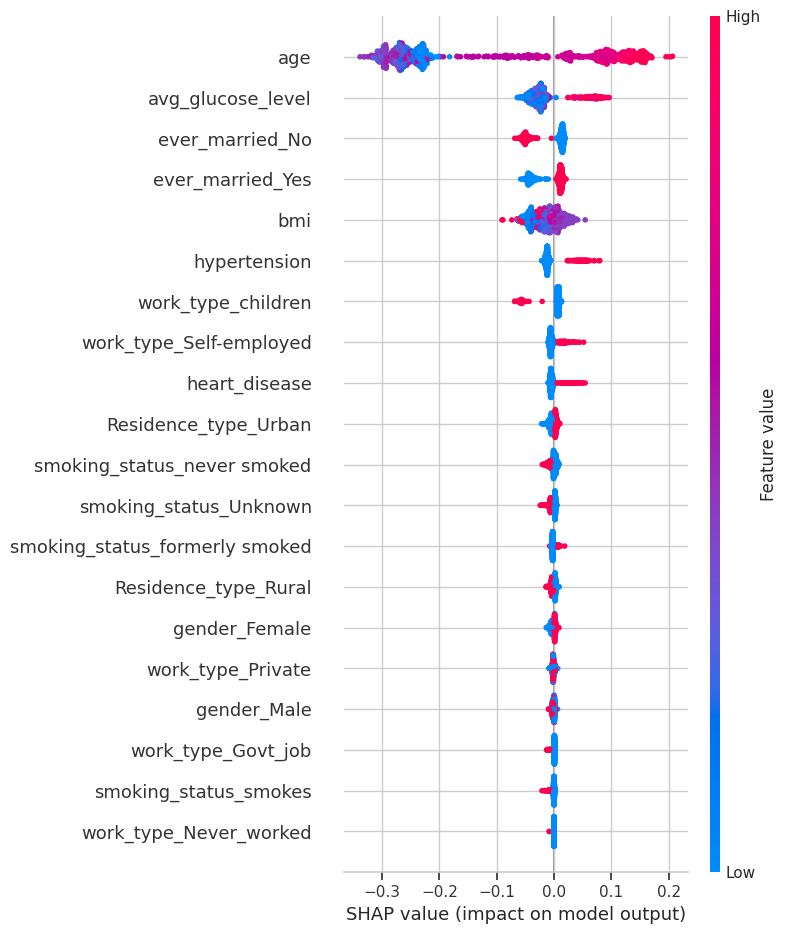

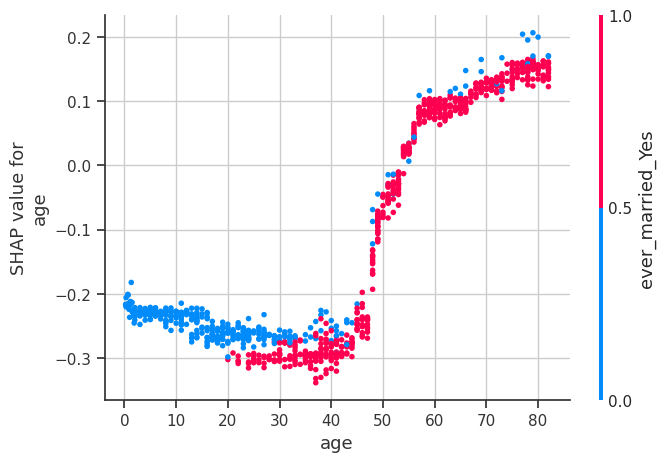

In [ ]:
# 11. SHAP global explainability - binary-class safe version

shap.initjs()

# For speed, sample a subset of training data
X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(best_model)

# Use modern API to get an Explanation object
shap_exp = explainer(X_train_sample)

# Extract raw values
shap_values_matrix = shap_exp.values
print("Original SHAP values shape:", shap_values_matrix.shape)
print("Sample data shape:", X_train_sample.shape)

# If 3D: (samples, features, outputs), pick class index 1 (stroke = 1)
if shap_values_matrix.ndim == 3:
    # shape: (1000, 20, 2) -> (1000, 20)
    shap_values_matrix = shap_values_matrix[:, :, 1]
    print("Reduced SHAP values shape (class 1 only):", shap_values_matrix.shape)
elif shap_values_matrix.ndim == 2:
    print("SHAP values already 2D, using as is.")
else:
    raise ValueError(f"Unexpected SHAP values shape: {shap_values_matrix.shape}")

# Global feature importance for stroke = 1
shap.summary_plot(
    shap_values_matrix,
    X_train_sample,
    feature_names=X_train.columns
)

# Optional: dependence-style plot for age.
# If it gives any error, you can comment this out, it is not required for your project.
if "age" in X_train.columns:
    shap.dependence_plot(
        "age",
        shap_values_matrix,
        X_train_sample,
        feature_names=X_train.columns
    )

### 5.2 Local explanation for a single patient using LIME

While SHAP provides a global view of feature importance, it is also useful to understand individual predictions. For this, I use **LIME (Local Interpretable Model agnostic Explanations)**.

LIME works by:

1. Taking a single instance from the test set.  
2. Generating many synthetic points around that instance by slightly perturbing its features.  
3. Getting predictions from the complex model for those perturbed points.  
4. Fitting a simple, interpretable model (such as a linear model) locally around that instance.

The LIME explanation shows:

- Which features increased the predicted probability of stroke for that specific patient.  
- Which features decreased it.  
- The approximate contribution size for each feature.

This helps answer the question:  
**“Why did the model predict high or low stroke risk for this particular patient?”**

In the written report, I will describe the main features driving the LIME explanation for one example case.


In [ ]:
# 12. LIME local explainability for one test patient
feature_names = X_train.columns.tolist()
class_names = ["No stroke", "Stroke"]

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True
)

# Pick a test instance index
i = 10  # you can change this to inspect different patients

x_test_instance = X_test.iloc[i].values

exp = lime_explainer.explain_instance(
    data_row=x_test_instance,
    predict_fn=best_model.predict_proba,
    num_features=10
)

# This will display inside Colab
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 6. Fairness Analysis by Gender

Machine learning models used in healthcare should not only be accurate, but also fair across different patient subgroups. As a simple fairness check, I examine performance by **gender** using the `fairlearn` library.

I treat `gender` as a sensitive feature and compute the following metrics by group (Male, Female):

- Accuracy  
- Selection rate (predicted positive rate)  
- False positive rate  
- True positive rate  

Using `MetricFrame`, I generate a table and bar plots that show how these metrics differ between genders.

In the written report, I will:

- Comment on any noticeable differences between groups.  
- Discuss whether the model appears to favor or disadvantage one gender in terms of false positives or false negatives.  
- Note that this is an initial and limited fairness analysis, and more thorough assessment would require additional sensitive attributes and clinical context.



Metrics by gender:
        accuracy  selection_rate  false_positive_rate  true_positive_rate
gender                                                                   
Female  0.701843        0.326633             0.302817            0.793103
Male    0.701176        0.324706             0.301980            0.761905


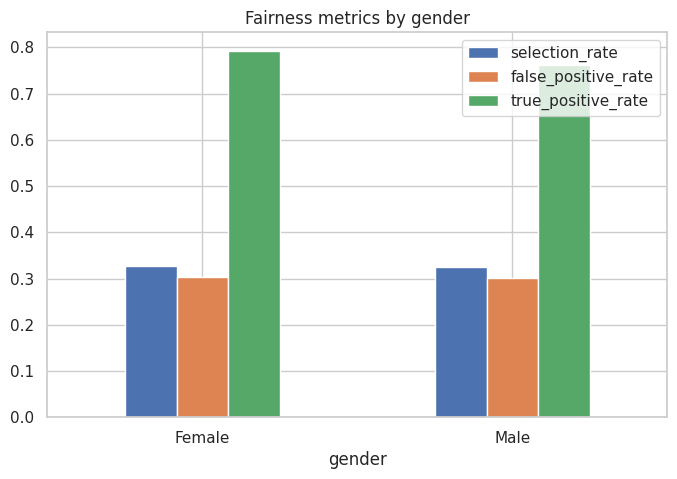

In [ ]:
# 13. Fairness analysis with Fairlearn (by gender)
# Sensitive feature: gender from the original cleaned dataframe
gender_test = df_clean.loc[X_test.index, "gender"]

metrics_dict = {
    "accuracy": accuracy_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

metric_frame = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred_best,
    sensitive_features=gender_test
)

print("\nMetrics by gender:")
print(metric_frame.by_group)

metric_frame.by_group[["selection_rate", "false_positive_rate", "true_positive_rate"]].plot(kind="bar")
plt.title("Fairness metrics by gender")
plt.xticks(rotation=0)
plt.show()

## 7. Interactive Deployment in Google Colab

The final part of this project is to deploy the tuned Random Forest model in a simple, user friendly way within Google Colab.

I implement a small interface using `ipywidgets.interact`:

1. **Input controls**  
   - Sliders for continuous variables such as age, average glucose level, and BMI.  
   - Dropdowns for categorical variables such as gender, work type, residence type, marital status, smoking status, hypertension, and heart disease.

2. **Encoding and prediction**  
   - The `build_input_row` function converts the chosen values into a single row that matches the one hot encoded feature space used for training.  
   - The `predict_stroke` function:
     - Applies the tuned Random Forest model to this input.  
     - Prints the predicted probability of stroke.  
     - Displays a message indicating whether the model classifies the patient as high or low stroke risk.

This interactive widget allows a user to:

- Experiment with different patient profiles.  
- See how changes in age, blood glucose, BMI, or risk factors affect the predicted stroke probability.  

It demonstrates a basic but functional deployment of the model inside Colab that satisfies the assignment requirement for model deployment and user interaction.


In [ ]:
# 14. Simple "deployment" in Colab with ipywidgets

feature_columns = X_train.columns.tolist()

def build_input_row(age, avg_glucose_level, bmi,
                    gender, ever_married, work_type,
                    residence_type, hypertension, heart_disease,
                    smoking_status):
    """
    Build a single-row DataFrame with the same columns as X_train,
    starting from raw input values.
    """
    # Start with all zeros
    row = pd.DataFrame(data=np.zeros((1, len(feature_columns))),
                       columns=feature_columns)

    # Numeric features
    if "age" in row.columns:
        row.loc[0, "age"] = age
    if "avg_glucose_level" in row.columns:
        row.loc[0, "avg_glucose_level"] = avg_glucose_level
    if "bmi" in row.columns:
        row.loc[0, "bmi"] = bmi
    if "hypertension" in row.columns:
        row.loc[0, "hypertension"] = hypertension
    if "heart_disease" in row.columns:
        row.loc[0, "heart_disease"] = heart_disease

    # Categorical one-hot columns follow the pattern column_category
    # gender
    gender_col = f"gender_{gender}"
    if gender_col in row.columns:
        row.loc[0, gender_col] = 1

    # ever_married
    ever_married_col = f"ever_married_{ever_married}"
    if ever_married_col in row.columns:
        row.loc[0, ever_married_col] = 1

    # work_type
    work_type_col = f"work_type_{work_type}"
    if work_type_col in row.columns:
        row.loc[0, work_type_col] = 1

    # residence_type
    residence_col = f"Residence_type_{residence_type}"
    if residence_col in row.columns:
        row.loc[0, residence_col] = 1

    # smoking_status
    smoking_col = f"smoking_status_{smoking_status}"
    if smoking_col in row.columns:
        row.loc[0, smoking_col] = 1

    return row


def predict_stroke(age, avg_glucose_level, bmi,
                   gender, ever_married, work_type,
                   residence_type, hypertension, heart_disease,
                   smoking_status):
    # Build encoded row
    row = build_input_row(
        age=age,
        avg_glucose_level=avg_glucose_level,
        bmi=bmi,
        gender=gender,
        ever_married=ever_married,
        work_type=work_type,
        residence_type=residence_type,
        hypertension=hypertension,
        heart_disease=heart_disease,
        smoking_status=smoking_status
    )

    prob = best_model.predict_proba(row)[0, 1]
    pred = best_model.predict(row)[0]

    print(f"Predicted stroke probability: {prob:.3f}")
    if pred == 1:
        print("Model prediction: HIGH STROKE RISK (1)")
    else:
        print("Model prediction: LOW STROKE RISK (0)")


print("\nUse the widgets below to try out different patient profiles:")

interact(
    predict_stroke,
    age=widgets.IntSlider(value=50, min=0, max=100, step=1, description="Age"),
    avg_glucose_level=widgets.FloatSlider(value=100.0, min=50.0, max=300.0, step=1.0,
                                          description="Glucose"),
    bmi=widgets.FloatSlider(value=25.0, min=10.0, max=60.0, step=0.5, description="BMI"),
    gender=widgets.Dropdown(options=["Male", "Female"], value="Female", description="Gender"),
    ever_married=widgets.Dropdown(options=["No", "Yes"], value="Yes", description="Ever married"),
    work_type=widgets.Dropdown(
        options=["Private", "Self-employed", "Govt_job", "Never_worked", "children"],
        value="Private", description="Work type"
    ),
    residence_type=widgets.Dropdown(
        options=["Urban", "Rural"], value="Urban", description="Residence"
    ),
    hypertension=widgets.Dropdown(options=[0, 1], value=0, description="Hypertension"),
    heart_disease=widgets.Dropdown(options=[0, 1], value=0, description="Heart disease"),
    smoking_status=widgets.Dropdown(
        options=["never smoked", "formerly smoked", "smokes", "Unknown"],
        value="never smoked", description="Smoking"
    )
)



Use the widgets below to try out different patient profiles:


interactive(children=(IntSlider(value=50, description='Age'), FloatSlider(value=100.0, description='Glucose', …

<function __main__.predict_stroke(age, avg_glucose_level, bmi, gender, ever_married, work_type, residence_type, hypertension, heart_disease, smoking_status)>

## 8. Summary and Next Steps

In this project, I:

- Defined a clinically meaningful classification problem, predicting stroke risk based on patient characteristics.  
- Selected and explored a real world health dataset from Kaggle.  
- Cleaned the data, handled missing values, and encoded categorical variables.  
- Trained and evaluated baseline models (Random Forest and Logistic Regression).  
- Tuned a Random Forest classifier using cross validation and hyperparameter search.  
- Assessed performance on a held out test set using accuracy, precision, recall, F1-score, and ROC AUC.  
- Applied SHAP and LIME to explain the global and local behavior of the tuned model.  
- Performed a simple fairness analysis by gender using the fairlearn library.  
- Deployed the final model inside Google Colab using an interactive widget for patient level predictions.

In the written report, I will expand on:

- The final performance metrics of the tuned model.  
- The main drivers of stroke risk identified by SHAP.  
- The LIME explanation for an example patient.  
- Any fairness concerns and potential mitigation ideas.  
- Limitations of the dataset and model, and suggestions for future work.

Overall, this notebook demonstrates the full lifecycle of an AI application in health analytics, starting from raw data and ending with an interpretable and interactive predictive model.
